In [52]:
# --- Standard Library ---
import os
import shutil
import random
import json
import csv
import warnings
from collections import defaultdict

# --- Scientific & Data Handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Image Handling ---
from PIL import Image
import cv2

# --- Progress Bar ---
from tqdm import tqdm

# --- PyTorch & Torchvision ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms

# --- Model Architectures ---
import timm

# --- Data Augmentation ---
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- Transformers / Huggingface ---
from transformers import AutoTokenizer, AutoModelForCausalLM

# --- Evaluation ---
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

# --- Environment & API ---
from openai import OpenAI
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

IMG_SIZE = 240
BATCH_SIZE = 32
NUM_CLASSES = 10  # Update based on your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Base paths (using raw string with backslashes)
original_data_dir = r'C:\Documents\Research Documents\wikiart'
base_dir = os.path.join(original_data_dir, 'wikiart_split')

# Subdirectories and files
json_path = os.path.join(original_data_dir, 'class_data.json')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

save_path = os.path.join(original_data_dir, 'efficientnet_art_model')
BEST_MODEL_PATH= os.path.join(original_data_dir, 'efficientnet_art_model', 'efficientnet_b0.pth')
model_path = os.path.join(original_data_dir, 'efficientnet_art_model', 'efficientnet_b0.pth')
image_dir = test_dir  # using the same test_dir for image_dir

gpt2_large_output_csv = os.path.join(original_data_dir, 'final_descriptions_gpt2.csv')
gpt2_large_log_file = os.path.join(original_data_dir, 'generation_log.txt')
gpt2_local_dir = os.path.join(original_data_dir, 'gpt2_large_local')

gpt4o_output_csv = os.path.join(original_data_dir, 'final_descriptions_gpt4o.csv')
gpt4o_log_file = os.path.join(original_data_dir, 'generation_log.txt')  # same as gpt2 log file

train_ratio = 0.8
val_ratio = 0.1

In [36]:
# --- Load JSON and Extract Class Names ---
with open(json_path, 'r') as f:
    data = json.load(f)

class_files = defaultdict(list)
for item in data:
    path = item[0]
    class_name, filename = path.split('/', 1)
    class_files[class_name].append(filename)

selected_classes = [
    'Abstract_Expressionism', 'Color_Field_Painting', 'Cubism',
    'Early_Renaissance', 'High_Renaissance', 'Mannerism_Late_Renaissance',
    'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Rococo'
]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024B2E4ED360>
Traceback (most recent call last):
  File "C:\Users\deven\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "C:\Users\deven\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [37]:
# --- Create or Reset Dataset Directory ---
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

print(f"Created base directory at: {base_dir}")

Created base directory at: C:\Documents\Research Documents\wikiart\wikiart_split


In [38]:
# --- Split and Copy Images ---
final_counts = {}

for class_name in tqdm(selected_classes, desc="Processing Classes"):
    src_folder = os.path.join(original_data_dir, class_name)
    if not os.path.exists(src_folder):
        continue

    for split in splits:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

    all_images = class_files[class_name]
    all_images = [img for img in all_images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(all_images)

    train_end = int(train_ratio * len(all_images))
    val_end = train_end + int(val_ratio * len(all_images))

    split_assignments = {
        'train': all_images[:train_end],
        'val': all_images[train_end:val_end],
        'test': all_images[val_end:]
    }

    final_counts[class_name] = {}
    for split, images in split_assignments.items():
        dest_dir = os.path.join(base_dir, split, class_name)
        for img in images:
            src_img_path = os.path.join(src_folder, img)
            dst_img_path = os.path.join(dest_dir, img)
            if os.path.exists(src_img_path):
                shutil.copy2(src_img_path, dst_img_path)
        final_counts[class_name][split] = len(images)

Processing Classes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.64s/it]


In [39]:
# --- Summary ---
summary = pd.DataFrame(final_counts).T
summary['total'] = summary.sum(axis=1)
summary = summary.sort_values(by='total', ascending=False)
summary.head()

,train,val,test,total
Abstract_Expressionism,2225,278,279,2782
Naive_Art_Primitivism,1924,240,241,2405
Cubism,1788,223,224,2235
Rococo,1671,208,210,2089
Color_Field_Painting,1292,161,162,1615


In [42]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [43]:
class ArtDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        self.data_dir = data_dir
        self.classes = {cls_name: i for i, cls_name in enumerate(classes)}
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for cls in classes:
            cls_folder = os.path.join(self.data_dir, cls)
            for img in os.listdir(cls_folder):
                if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(cls_folder, img))
                    self.labels.append(self.classes[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        try:
            image = cv2.imread(img_path)
            if image is None:
                return self.__getitem__((idx + 1) % len(self))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(image=image)['image']
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))


In [44]:
train_dataset = ArtDataset(train_dir, selected_classes, transform=train_transform)
val_dataset = ArtDataset(val_dir, selected_classes, transform=val_test_transform)
test_dataset = ArtDataset(test_dir, selected_classes, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 14364, Val: 1791, Test: 1804


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --- Transforms (Strong Augmentation) ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# --- Load Dataset & Stratified Split ---
full_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
targets = full_dataset.targets
NUM_CLASSES = len(full_dataset.classes)
print(f"Using {NUM_CLASSES} classes")

# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
indices = list(range(len(full_dataset)))
train_idx, val_idx = next(sss.split(indices, targets))

train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
val_subset.dataset.transform = val_transform

# --- Weighted Sampler ---
labels = [full_dataset.targets[i] for i in train_idx]
class_sample_count = np.array([labels.count(t) for t in range(NUM_CLASSES)])
weights = 1. / class_sample_count
samples_weights = [weights[t] for t in labels]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

# --- DataLoaders ---
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# --- Model: EfficientNet-B0 ---
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=NUM_CLASSES)
for param in model.parameters():
    param.requires_grad = True

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.6),              # Increased dropout
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.6),              # Increased dropout
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(device)

# --- Loss, Optimizer, Scheduler ---
train_criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
val_criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# --- Training Loop (No early stopping) ---
def train_and_evaluate(model, train_loader, val_loader, num_epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = train_criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy_metric(outputs, labels).item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = val_criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy_metric(outputs, labels).item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    print("Training Complete.")
    return history

# --- Train the Model ---
history = train_and_evaluate(model, train_loader, val_loader, num_epochs=EPOCHS)

# --- Save the Model ---
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, "efficientnet_b0.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Device: cpu
Using 10 classes


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:52<00:00,  1.24s/it]


Epoch 1: Train Loss=1.9237, Acc=0.4236 | Val Loss=1.5063, Acc=0.6471


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:47<00:00,  1.20s/it]


Epoch 2: Train Loss=1.5742, Acc=0.6285 | Val Loss=1.4135, Acc=0.7128


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:49<00:00,  1.21s/it]


Epoch 3: Train Loss=1.4411, Acc=0.7139 | Val Loss=1.3721, Acc=0.7343


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:54<00:00,  1.27s/it]


Epoch 4: Train Loss=1.3628, Acc=0.7654 | Val Loss=1.3575, Acc=0.7440


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:47<00:00,  1.19s/it]

Epoch 5: Train Loss=1.3358, Acc=0.7836 | Val Loss=1.3610, Acc=0.7430
Training Complete.
Model saved at: C:\Documents\Research Documents\wikiart\efficientnet_art_model\efficientnet_b0.pth


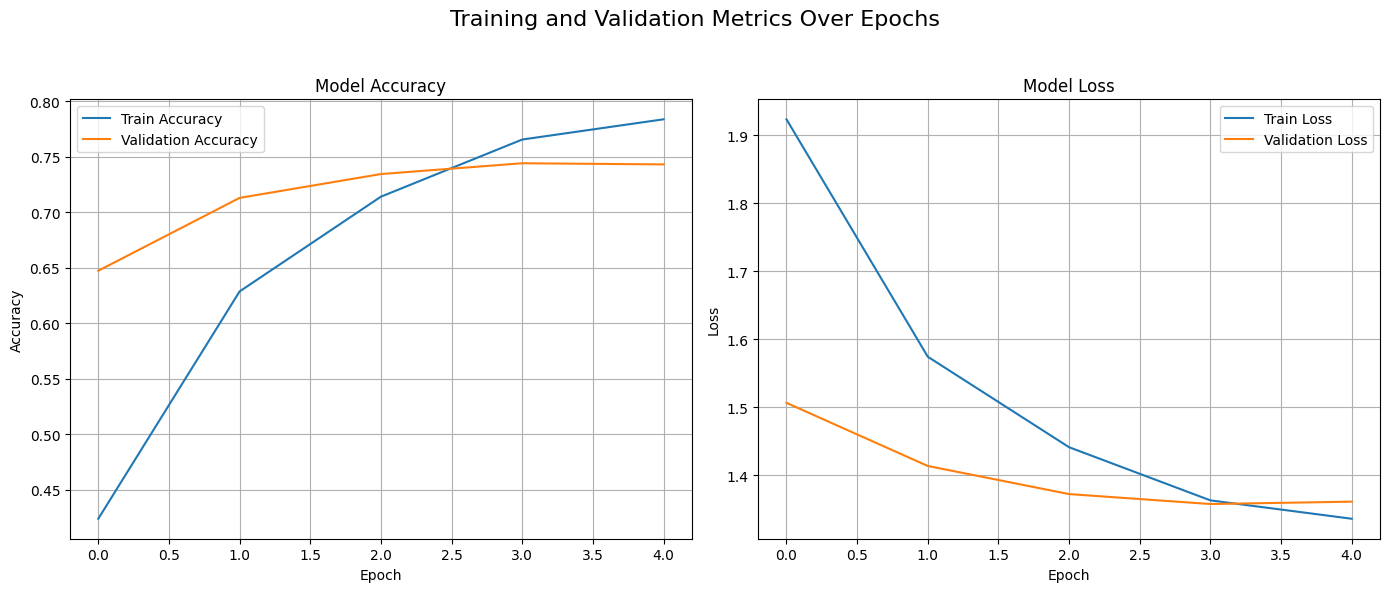

In [46]:
import matplotlib.pyplot as plt

# --- Plot Training History ---
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Save to file (before showing)
plt.savefig('C:/Documents/Research Documents/training_metrics.png', dpi=300)  # saves as high-quality PNG
plt.show()


In [53]:
# --- Device Check ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

# --- Safe DataLoader Settings ---
test_loader = DataLoader(
    val_subset,            # Replace with test_dataset if you have a separate one
    batch_size=64,         # Safe for inference
    shuffle=False,
    num_workers=0,         # Critical for Windows, especially in notebooks
    pin_memory=False       # Only use True if on GPU
)

if os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    model = model.to(device)
    print(f"Loaded best model from: {BEST_MODEL_PATH}")
else:
    print("No saved model found. Using current model in memory.")

# --- Run Inference ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Final Testing", total=len(test_loader)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=selected_classes, digits=4))

Device in use: cpu
Loaded best model from: C:\Documents\Research Documents\wikiart\efficientnet_art_model\efficientnet_b0.pth


Final Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:30<00:00,  3.34s/it]


Classification Report:

                            precision    recall  f1-score   support

    Abstract_Expressionism     0.7977    0.6292    0.7035       445
      Color_Field_Painting     0.7158    0.8101    0.7600       258
                    Cubism     0.8086    0.7905    0.7994       358
         Early_Renaissance     0.7051    0.7432    0.7237       222
          High_Renaissance     0.6018    0.6326    0.6168       215
Mannerism_Late_Renaissance     0.6784    0.6585    0.6683       205
                Minimalism     0.6883    0.7944    0.7375       214
     Naive_Art_Primitivism     0.8648    0.7143    0.7824       385
                   Pop_Art     0.5588    0.7215    0.6298       237
                    Rococo     0.8886    0.9311    0.9094       334

                  accuracy                         0.7431      2873
                 macro avg     0.7308    0.7425    0.7331      2873
              weighted avg     0.7531    0.7431    0.7440      2873




Confusion Matrix:



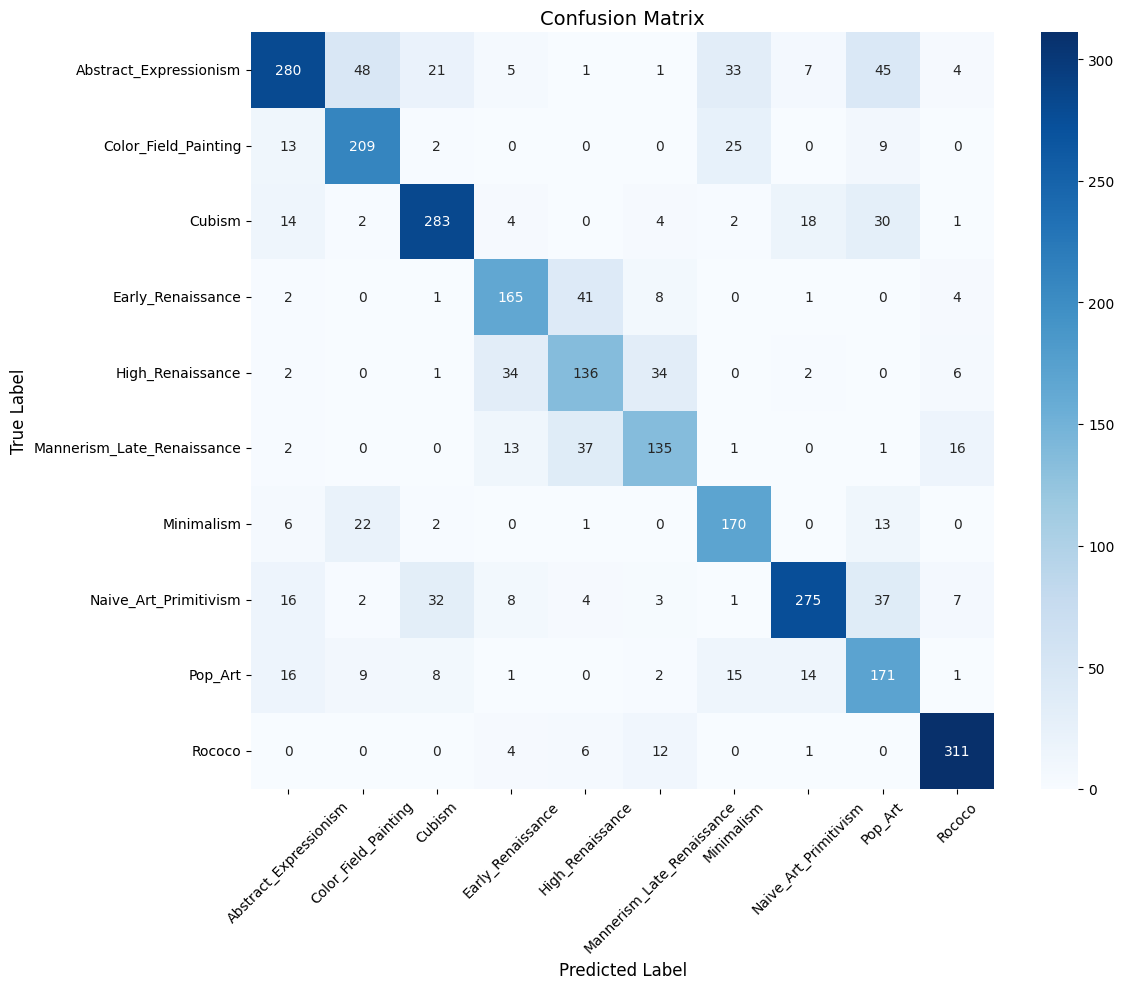

In [54]:
# --- Confusion Matrix ---
print("\nConfusion Matrix:\n")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('C:/Documents/Research Documents/confusion_matrix.png', dpi=300)  # saves as high-quality PNG
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# --- Get Class Names ---
class_names = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])
NUM_CLASSES = len(class_names)

# --- Load EfficientNet-B0 Model ---
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval().to(device)
print("EfficientNet-B0 model loaded.")

# --- Image Transform ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# --- Predict Classes ---
image_entries = []
for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(root, file)
            try:
                img = Image.open(path).convert("RGB")
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(img_tensor)
                    pred = torch.argmax(output, dim=1).item()
                    pred_class = class_names[pred]
                image_entries.append({
                    "file_path": path,
                    "file_name": file,
                    "predicted_class": pred_class
                })
            except Exception as e:
                print(f"Skipped {file}: {e}")

df = pd.DataFrame(image_entries)
print(f"Predictions done for {len(df)} images.")
if df.empty:
    print("No valid images found.")
    exit()

# --- Build Prompts ---
descriptive_phrases = [
    "featuring intricate color dynamics and expressive textures",
    "capturing raw emotion through chaotic brushstrokes",
    "blending geometric shapes and surreal symmetry",
    "conveying mood through minimalistic composition",
    "highlighting bold contrasts and visual rhythm",
    "filled with layered symbolism and movement"
]

df["prompt"] = df.apply(
    lambda row: (
        f"A painting titled '{row['file_name']}' in the style of {row['predicted_class']}. "
        f"The artwork is {random.choice(descriptive_phrases)}. "
        "Write a vivid and detailed artistic interpretation of this painting, focusing on visual elements, emotion, and context."
    ),
    axis=1
)

# --- Load GPT-2 Model ---
if not os.path.exists(gpt2_local_dir):
    print("Downloading GPT-2 Large...")
    tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
    model_lm = AutoModelForCausalLM.from_pretrained("gpt2-large")
    tokenizer.save_pretrained(gpt2_local_dir)
    model_lm.save_pretrained(gpt2_local_dir)
else:
    print("Loading GPT-2 Large from local...")
    tokenizer = AutoTokenizer.from_pretrained(gpt2_local_dir)
    model_lm = AutoModelForCausalLM.from_pretrained(gpt2_local_dir)

model_lm.eval().to(device)

# --- Description Generator ---
def generate_description(prompt, max_tokens=200):
    try:
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
        total_length = min(input_ids.shape[1] + max_tokens, 1024)

        with torch.no_grad():
            output = model_lm.generate(
                input_ids,
                max_length=total_length,
                do_sample=True,
                temperature=0.9,
                top_k=50,
                top_p=0.95,
                pad_token_id=tokenizer.eos_token_id
            )

        decoded = tokenizer.decode(output[0], skip_special_tokens=True)
        return decoded[len(prompt):].strip()
    except Exception as e:
        return f"ERROR: {str(e)}"

# --- Save Output Safely ---
with open(gpt2_large_output_csv, "w", encoding="utf-8", newline="") as csvfile, \
     open(gpt2_large_log_file, "w", encoding="utf-8") as logfile:

    writer = csv.writer(csvfile)
    writer.writerow(["file_name", "predicted_class", "full_generated_description"])

    total = len(df)
    for i, row in df.iterrows():
        print(f"[{i+1}/{total}]  {row['file_name']} — generating description...")
        try:
            description = generate_description(row["prompt"])
            clean_desc = description.replace("\n", " ").replace("\r", "").strip()
            writer.writerow([row["file_name"], row["predicted_class"], clean_desc])
            logfile.write(f"[{i+1}] {row['file_name']} — {clean_desc}\n")
            csvfile.flush()
            logfile.flush()
        except Exception as e:
            print(f"Failed on {row['file_name']}: {e}")
            writer.writerow([row["file_name"], row["predicted_class"], f"ERROR: {str(e)}"])
            logfile.write(f"[{i+1}] {row['file_name']} — ERROR: {str(e)}\n")

print(f"\nAll descriptions saved to: {gpt2_large_output_csv}")

Device: cpu
EfficientNet-B0 model loaded.
Predictions done for 1804 images.
Loading GPT-2 Large from local...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[1/1804]  aaron-siskind_pleasures-and-terrors-of-levitation-25-1957.jpg — generating description...
[2/1804]  abidin-dino_abstract-composition.jpg — generating description...


In [ ]:
# --- Load API Key ---
load_dotenv()
client = OpenAI(api_key="OPEN-AI-KEY")

# --- Configuration ---
caption_placeholder = "The image shows a detailed painting with complex brushwork and abstract shapes."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# --- Load Class Names ---
class_names = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])
NUM_CLASSES = len(class_names)

# --- Load Model ---
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval().to(device)
print("EfficientNet-B0 model loaded.")

# --- Image Transform ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# --- Predict Classes ---
image_entries = []
print("Scanning images...")
for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(root, file)
            try:
                img = Image.open(path).convert("RGB")
                img_tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(img_tensor)
                    pred = torch.argmax(output, dim=1).item()
                    pred_class = class_names[pred]
                image_entries.append({
                    "file_path": path,
                    "file_name": file,
                    "predicted_class": pred_class,
                    "caption": caption_placeholder
                })
            except Exception as e:
                print(f"Skipped {file}: {e}")

df = pd.DataFrame(image_entries)
print(f"✅ Predictions done for {len(df)} images.")
if df.empty:
    print("No images found. Exiting.")
    exit()

# --- Build Prompts ---
df["prompt"] = df.apply(
    lambda row: (
        f"A painting in the style of {row['predicted_class']}. "
        f"The image shows: {row['caption']}. "
        "Describe this painting vividly, including its composition, mood, and artistic expression."
    ),
    axis=1
)

# --- GPT-4o Description Generator ---
def generate_description(prompt, max_tokens=250):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are an art expert who writes interpretive descriptions for paintings."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=0.9,
            top_p=0.95,
            frequency_penalty=0.2,
            presence_penalty=0.3
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"ERROR: {str(e)}"

# --- Save Descriptions ---
with open(gpt4o_output_csv, "w", encoding="utf-8", newline="") as csvfile, \
     open(gpt4o_log_file, "w", encoding="utf-8") as logfile:

    writer = csv.writer(csvfile)
    writer.writerow(["file_name", "predicted_class", "full_generated_description"])

    total = len(df)
    for i, row in df.iterrows():
        print(f"[{i+1}/{total}] Processing {row['file_name']}...")

        try:
            description = generate_description(row["prompt"])
            clean_desc = description.replace("\n", " ").replace("\r", "").strip()

            writer.writerow([row["file_name"], row["predicted_class"], clean_desc])
            logfile.write(f"[{i+1}/{total}] {row['file_name']} — {clean_desc}\n")

            # Optional flush for safety
            csvfile.flush()
            logfile.flush()

        except Exception as e:
            error_msg = f"ERROR: {str(e)}"
            writer.writerow([row["file_name"], row["predicted_class"], error_msg])
            logfile.write(f"[{i+1}/{total}] {row['file_name']} — {error_msg}\n")
            print(f"Error on {row['file_name']}: {error_msg}")

print(f"\nAll descriptions saved to: {gpt4o_output_csv}")